# Embeddings with PyTorch Geometric

Node, Edge, and Graph Embeddings using GCN and pooling techniques.

In [ ]:
# Install PyTorch (change version if needed)
# Check: https://pytorch.org/get-started/locally/

# CPU-only install of PyTorch and PyG
!pip install torch torchvision torchaudio

# Install PyTorch Geometric dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 857.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

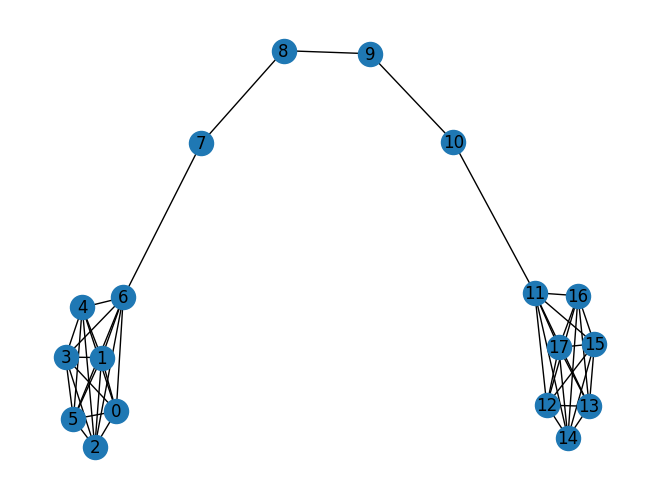

In [ ]:
# Create a barbell graph using NetworkX and convert to PyG
G = nx.barbell_graph(m1=7, m2=4)
nx.draw(G, with_labels=True)
plt.show()

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # make undirected

# Add dummy features (e.g., degree or identity)
x = torch.eye(G.number_of_nodes(), dtype=torch.float)

data = Data(x=x, edge_index=edge_index)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):  # ✅ Add batch here
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return global_mean_pool(x, batch)  # ✅ Use batch for graph embedding



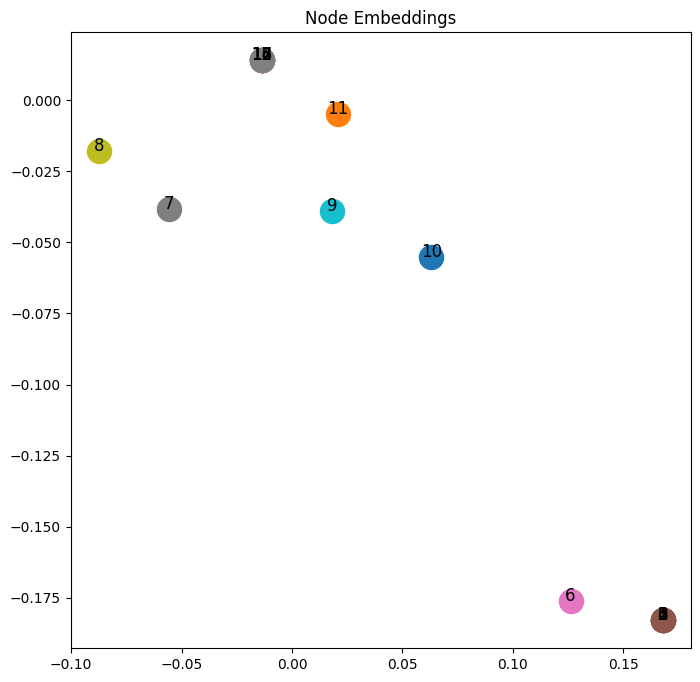

In [ ]:
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)

node_embeddings_np = node_embeddings.numpy()
plt.figure(figsize=(8, 8))
for i in range(len(node_embeddings_np)):
    plt.scatter(*node_embeddings_np[i], s=300)
    plt.text(*node_embeddings_np[i], str(i), fontsize=12, ha='center')
plt.title("Node Embeddings")
plt.show()


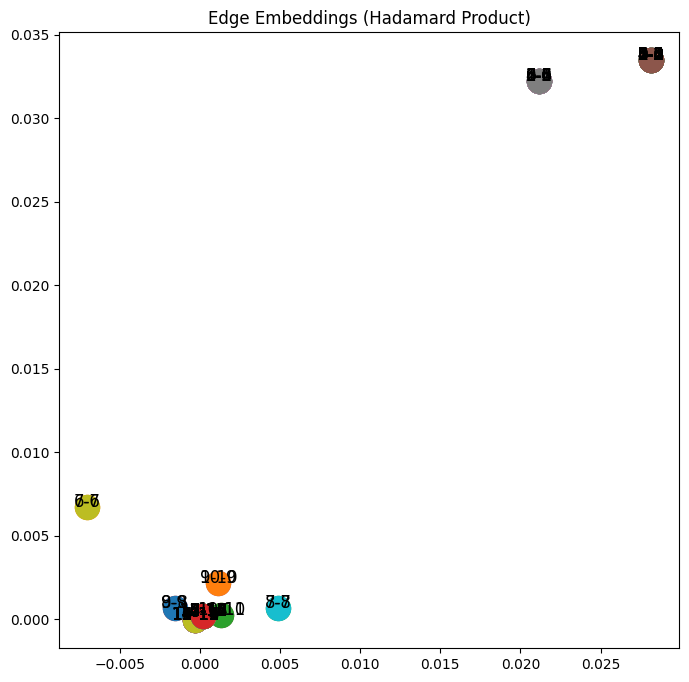

In [ ]:
def hadamard(u, v):
    return u * v

edges = data.edge_index.t().numpy()
edge_embeddings = []
for i, j in edges:
    emb = hadamard(node_embeddings[i], node_embeddings[j])
    edge_embeddings.append(emb.numpy())

edge_embeddings = np.array(edge_embeddings)

plt.figure(figsize=(8, 8))
for idx, (i, j) in enumerate(edges):
    plt.scatter(*edge_embeddings[idx], s=300)
    plt.text(*edge_embeddings[idx], f"{i}-{j}", fontsize=12, ha='center')
plt.title("Edge Embeddings (Hadamard Product)")
plt.show()


In [ ]:
def generate_ws_graphs(n_graphs=20, n_nodes=20, k=4, p=0.3):
    data_list = []
    for _ in range(n_graphs):
        G = nx.watts_strogatz_graph(n=n_nodes, k=k, p=p)
        edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # make undirected
        x = torch.eye(n_nodes, dtype=torch.float)  # identity features
        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
    return data_list

graphs = generate_ws_graphs()



In [ ]:
model = GCN(in_channels=20, hidden_channels=16, out_channels=2)
model.eval()

# Add batch information
for i, data in enumerate(graphs):
    data.batch = torch.full((data.num_nodes,), i, dtype=torch.long)

# Combine all graphs
batch = torch.cat([d.batch for d in graphs])
x = torch.cat([d.x for d in graphs])
edge_index_list = []
offset = 0
for d in graphs:
    edge_index_list.append(d.edge_index + offset)
    offset += d.num_nodes
edge_index = torch.cat(edge_index_list, dim=1)

with torch.no_grad():
    graph_embeddings = model(x, edge_index, batch)

print("Shape of graph embeddings:", graph_embeddings.shape)

Shape of graph embeddings: torch.Size([20, 2])


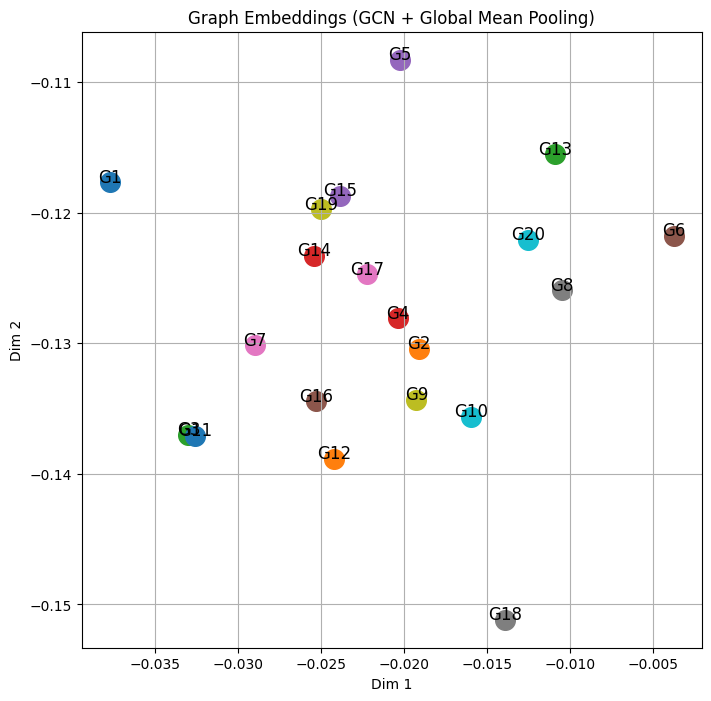

In [ ]:
emb_np = graph_embeddings.numpy()
plt.figure(figsize=(8, 8))
for i in range(len(emb_np)):
    plt.scatter(*emb_np[i], s=200)
    plt.text(*emb_np[i], f"G{i+1}", fontsize=12, ha='center')
plt.title("Graph Embeddings (GCN + Global Mean Pooling)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

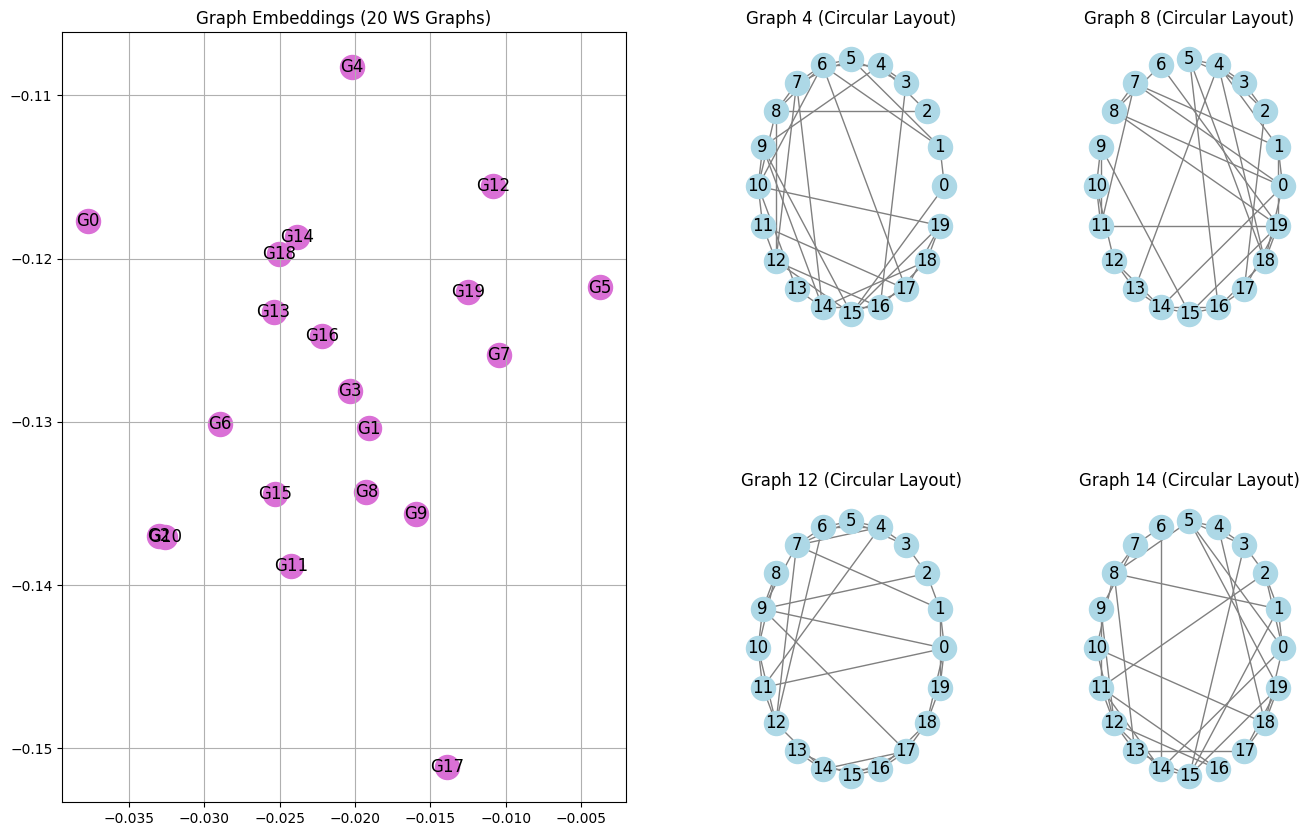

In [15]:
selected_indices = [4, 8, 12, 14]
selected_graphs = [graphs[i] for i in selected_indices]
selected_Gs = [to_networkx(g, to_undirected=True) for g in selected_graphs]

fig = plt.figure(figsize=(16, 10))
grid = plt.GridSpec(2, 4, wspace=0.5, hspace=0.5)

# Graph embeddings
ax0 = fig.add_subplot(grid[:, :2])
ax0.scatter(graph_embeddings[:, 0], graph_embeddings[:, 1], s=300, c='orchid')
for i, (x_, y_) in enumerate(graph_embeddings):
    ax0.text(x_, y_, f"G{i}", fontsize=12, ha='center', va='center')
ax0.set_title("Graph Embeddings (20 WS Graphs)")
ax0.grid(True)

# Selected graphs in circular layout
for i, idx in enumerate(selected_indices):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(grid[row, col + 2])
    G = selected_Gs[i]
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray')
    ax.set_title(f"Graph {idx} (Circular Layout)")

plt.show()
